## Running topic modeling

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import gensim

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.6/dist-packages/paramiko/transport.py:33: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


In [2]:
# Turn string of text in list of words
def tokenize(docs, tokenizer):
    docs = [doc.lower() for doc in docs]
    docs = [tokenizer.tokenize(doc) for doc in docs]
    docs = [[d.strip() for d in doc if d.strip()] for doc in docs]
    docs = [' '.join(doc).split(' ') for doc in docs]
    
    return docs

# Remove stopwords define in nltk
def clen_words(docs, stopwords=set()):
    bag = [[word for word in doc if valid_word(word, stopwords)] for doc in docs]  
    
    return bag

# Define what is a valid word
def valid_word(word, stopwords):
    return (word not in stopwords and len(word) >= 3 and not word.isnumeric())

def lemmatize(docs, lemmatizer):
    return [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [3]:
# Import data and define initial documents
df = pd.read_csv('data/modelling.csv', index_col=0)

# Fill empty Author Keywords values with empty string
df['author_keywords'] = df['author_keywords'].fillna('')
df['abstract'] = df['abstract'].fillna('')

# Make Year and number of citations a integer
df['year'] = df['year'].astype('Int64')
df['number_citation'] = df['number_citation'].astype('Int64')

docs = df['title'] + ' ' + df['abstract'] + ' ' + df['author_keywords']

In [4]:
# Tokenize and clean documents
new_stopwords = ['research', 'review', 'literature', 'analysis']
stopwords = nltk.corpus.stopwords.words('english') + new_stopwords
tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w|\-]+')
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

docs = tokenize(docs, tokenizer)
docs = clen_words(docs, stopwords)
docs = lemmatize(docs, lemmatizer)

In [5]:
# Add bigrams to documents
bigram = gensim.models.Phrases(docs, min_count=30)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

In [6]:
# Parameters of the model
no_below=50; no_above=0.7; keep_n=5000; num_topics = 5; passes=10; iterations=5000; random_state=4

# Create dictionary and corpus
dictionary = gensim.corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)

corpus = [dictionary.doc2bow(doc) for doc in docs]

# Fit model
LDA_model = gensim.models.LdaModel(corpus, id2word=dictionary, passes=passes, 
                                   chunksize=1000, iterations=iterations,
                                   num_topics=num_topics, eval_every=None, random_state=random_state)

# Print results
topics_matrix = LDA_model.show_topics(formatted=False, num_words=7)
for i in topics_matrix:
    print(f'Topic {i[0] + 1}: {[str(pair[0]) for pair in i[1]]}')
    
# Compute model coherence
coherecenmodel = gensim.models.coherencemodel.CoherenceModel(model=LDA_model, texts=docs, coherence='c_v')
print(f'Model coherece {coherecenmodel.get_coherence()}')

Topic 1: ['health', 'study', 'factor', 'stress', 'result', 'social', 'scale']
Topic 2: ['system', 'risk', 'study', 'supply', 'urban', 'approach', 'chain']
Topic 3: ['system', 'network', 'proposed', 'power', 'energy', 'optimization', 'water']
Topic 4: ['change', 'ecosystem', 'climate', 'forest', 'specie', 'dynamic', 'water']
Topic 5: ['network', 'dynamic', 'system', 'data', 'using', 'result', 'method']
Model coherece 0.49108731967486613


In [7]:
# Visualize results
roots_data = pyLDAvis.gensim.prepare(LDA_model, corpus, dictionary)
pyLDAvis.display(roots_data)

## Selecting papers inside topic model

In [8]:
# Based on the result of the topic modeling, fill topic for each paper
df['topic'] = 0
for idx in range(len(corpus)):
    topic_number = sorted(LDA_model[corpus[idx]], reverse=True, key=lambda element: element[1])[0][0] + 1
    df.loc[idx, 'topic'] = int(topic_number)

df[['title', 'journal_name', 'topic']].assign(tokens=docs).head()

,title,journal_name,topic,tokens
index,,,,
0,Psychometric Properties and Contribution to Me...,Folia medica,1,"[psychometric, property, contribution, mental,..."
1,Spatiotemporal variation analysis of regional ...,Journal of cleaner production,2,"[spatiotemporal, variation, regional, flood, d..."
2,Pushing the limit of quantum transport simulat...,Physical review research,5,"[pushing, limit, quantum, transport, simulatio..."
3,Metrics and Models for Quantifying Ecological ...,Frontiers in ecology and evolution,4,"[metric, model, quantifying, ecological, resil..."
4,A complex systems framework for the sustainabi...,People and nature,2,"[complex, system, framework, sustainability, d..."


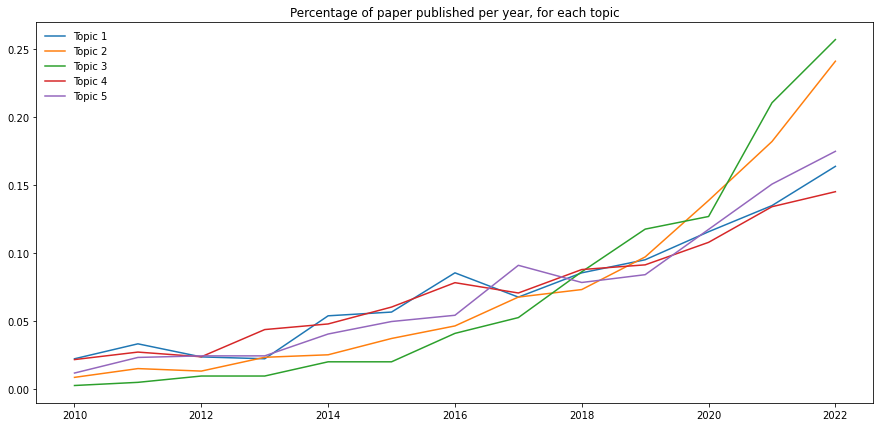

In [9]:
# Plot percentage of publication per year, inside topic
sns.set_context(rc = {'patch.linewidth': 0.0})
plt.figure(figsize=(15, 7))

years = np.arange(2010, 2023)
for topic in range(num_topics):
    dfTopic = df[df['topic'] == topic + 1]
    total_num_results = len(dfTopic)
    num_results = [(dfTopic['year'] == year).sum() / total_num_results for year in years] 
    sns.lineplot(x=years, y=num_results, label=f"Topic {topic + 1}") 

plt.title('Percentage of paper published per year, for each topic')
plt.legend()
plt.show()

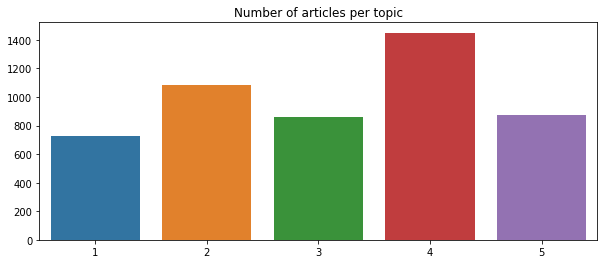

In [10]:
# Plot bar chart of the number of papers in each topic
plt.figure(figsize=(10, 4))

group_size = [len(group) for name, group in df.groupby('topic')]
topic = np.arange(0, num_topics) + 1
sns.barplot(x=topic, y=group_size)

plt.title('Number of articles per topic')
plt.show()

In [11]:
# Print the three most common journal per topic
number_journals = 5
for topic in range(num_topics):
    dfTopic = df[df['topic'] == topic + 1]
    dfJournalCount = dfTopic['journal_name'].value_counts().head(number_journals)
    name_of_journals = list(dfJournalCount.index)
    number_of_occurences = list(dfJournalCount.values)
    
    print(f'Topic {topic + 1}, size {len(dfTopic)}')
    for idx in range(number_journals): print(f'name: {name_of_journals[idx]}, occurences: {number_of_occurences[idx]}')
    print()

Topic 1, size 728
name: Plos one, occurences: 41
name: International journal of environmental research and public health, occurences: 16
name: Bmj open, occurences: 13
name: Frontiers in psychology, occurences: 12
name: Journal of affective disorders, occurences: 11

Topic 2, size 1084
name: Sustainability (switzerland), occurences: 69
name: International journal of disaster risk reduction, occurences: 31
name: International journal of production research, occurences: 30
name: Journal of cleaner production, occurences: 25
name: Natural hazards, occurences: 20

Topic 3, size 861
name: Reliability engineering and system safety, occurences: 71
name: Applied energy, occurences: 28
name: Ieee transactions on smart grid, occurences: 27
name: Ieee access, occurences: 26
name: Ieee transactions on power systems, occurences: 24

Topic 4, size 1450
name: Science of the total environment, occurences: 42
name: Plos one, occurences: 42
name: Ecological indicators, occurences: 38
name: Ecological mo

In [12]:
selected_journals = ['Bmj open', 'International journal of disaster risk reduction', 'Applied energy', 
                     'Ecological modelling', 'Journal of theoretical biology']

total_papers_selected = 0
for journal_name in selected_journals:
    dfJournal = df[df['journal_name'] == journal_name]
    total_papers_selected += len(dfJournal)
    print(f'There is {len(dfJournal)} papers of the journal {journal_name}.')
print(f'The total number of articles is {len(df)}, {total_papers_selected} are in the selected journals ' \
      f'({round(100 * total_papers_selected / len(df), 1)}%)')

There is 13 papers of the journal Bmj open.
There is 43 papers of the journal International journal of disaster risk reduction.
There is 32 papers of the journal Applied energy.
There is 34 papers of the journal Ecological modelling.
There is 22 papers of the journal Journal of theoretical biology.
The total number of articles is 4994, 144 are in the selected journals (2.9%)


In [13]:
# Saving csv with most cited and newer papers per topic
dfReduced = df.drop(columns=['abstract', 'references'])

with pd.ExcelWriter("data/modelling_journals.xlsx") as writer:
    for journal_name in selected_journals:
        dfJournal = df[df['journal_name'] == journal_name].sort_values(by=['number_citation'], ascending=False, na_position='last')
        dfJournal.to_excel(writer, sheet_name=f'{journal_name}', index=False)

/home/vitor/.local/lib/python3.6/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
